In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2

import keras
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.merge import concatenate
from keras.layers import UpSampling2D, Conv2D, Activation, Input, Dropout, MaxPooling2D
from keras import Model
from keras import backend as K
from keras.layers.core import Lambda

Using TensorFlow backend.


In [2]:
tr = pd.read_csv('../input/train.csv')
tr = tr.reindex(np.random.permutation(tr.index))
print(len(tr))
tr.head()

50272


,ImageId_ClassId,EncodedPixels
9620,306b1dbc1.jpg_1,NaN
609,03284f71b.jpg_2,NaN
20121,6634574cd.jpg_2,NaN
32127,a36c9a89e.jpg_4,NaN
19243,620100d93.jpg_4,NaN


In [3]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
print(len(df_train))
df_train.head()

7095


,ImageId_ClassId,EncodedPixels
0,a567b95ad.jpg_3,44 42 288 89 532 101 782 107 1037 108 1293 107...
1,c33e20d0b.jpg_3,265023 3 265277 10 265532 17 265787 23 266041 ...
2,aa4b29d91.jpg_3,42753 37 43009 111 43265 148 43521 148 43777 1...
3,1f9863963.jpg_4,231143 5 231389 17 231640 24 231894 28 232149 ...
4,2e12e1c6a.jpg_3,279804 5 280057 8 280311 10 280565 12 280817 1...


In [48]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [6]:
img_size = 256

In [29]:
def keras_generator(batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):            
            fn = df_train['ImageId_ClassId'].iloc[i].split('_')[0]
            img = cv2.imread( '../input/train_images/'+fn )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            
            mask = rle2mask(df_train['EncodedPixels'].iloc[i], img.shape)
            img = cv2.resize(img, (img_size, img_size))
            mask = cv2.resize(mask, (img_size, img_size))
            
            x_batch += [img]
            y_batch += [mask]
                                    

        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [30]:
def train_keras_generator(batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):            
            fn = df_train['ImageId_ClassId'].iloc[i].split('_')[0]
            img = cv2.imread( '../input/train_images/'+fn )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            
            mask = rle2mask(df_train['EncodedPixels'].iloc[i], img.shape)
            img = cv2.resize(img, (img_size, img_size))
            mask = cv2.resize(mask, (img_size, img_size))

            x_batch += [img]
            y_batch += [[cv2.bitwise_and(img,img,mask = mask)]]

        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [49]:
for x, y in keras_generator(10):
    break
    
#print(x.shape, y.shape)

for x_d_test, y_d_test in train_keras_generator(10):
    break

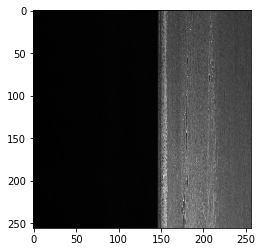

In [50]:
plt.imshow(x[4])

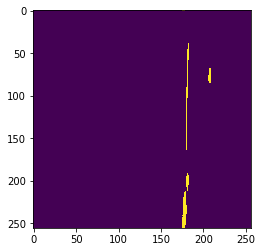

In [51]:
plt.imshow(np.squeeze(y[4]))

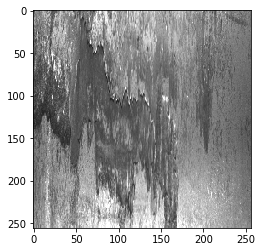

In [52]:
plt.imshow(np.squeeze(x_d_test[6]))

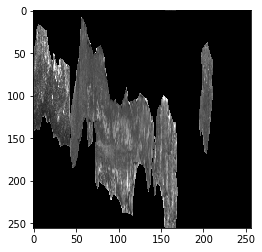

In [53]:
plt.imshow(np.squeeze(y_d_test[6]))

In [54]:
#Model

inputs = Input((256, 256, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')

In [55]:
%%time
# Fit model
batch_size = 10
results = model.fit_generator(keras_generator(batch_size), 
                              steps_per_epoch=100,
                              epochs=20) 

Epoch 1/20
100/100 [==============================] - 13s 126ms/step - loss: 0.2468
Epoch 2/20
100/100 [==============================] - 10s 96ms/step - loss: 0.2096
Epoch 3/20
100/100 [==============================] - 10s 96ms/step - loss: 0.2064
Epoch 4/20
100/100 [==============================] - 10s 96ms/step - loss: 0.1825
Epoch 5/20
100/100 [==============================] - 10s 97ms/step - loss: 0.0823
Epoch 6/20
100/100 [==============================] - 10s 97ms/step - loss: 0.0207
Epoch 7/20
100/100 [==============================] - 10s 98ms/step - loss: 0.0102
Epoch 8/20
100/100 [==============================] - 10s 97ms/step - loss: 0.0073
Epoch 9/20
100/100 [==============================] - 10s 96ms/step - loss: 0.0057
Epoch 10/20
100/100 [==============================] - 10s 102ms/step - loss: 0.0046
Epoch 11/20
100/100 [==============================] - 10s 96ms/step - loss: 0.0482
Epoch 12/20
100/100 [==============================] - 10s 97ms/step - loss: 0.1953

0.04450152441859245


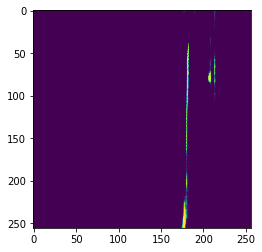

In [59]:
pred = model.predict(x)
plt.imshow(np.squeeze(pred[4]))
score = model.evaluate(x, y, verbose=0)
print(score)